# Bert Partition

## Imports

In [1]:
# ! pip install transformers[torch] datasets evaluate wandb minio tqdm scipy

In [2]:
# ! pip install gudhi ripser giotto-tda scikit-tda

In [3]:
# ! pip install torch_optimizer

In [4]:
import datasets
import pickle as pkl
import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    DataCollatorForWholeWordMask,
    DefaultDataCollator,
    default_data_collator,
    BertForMaskedLM,
    get_scheduler,
    TrainingArguments,
    Trainer
)
import transformers
import evaluate
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
import torch_optimizer as optim
# from maskedtensor import masked_tensor

from tqdm.auto import trange, tqdm
import pandas as pd
from collections import defaultdict
import io
import pathlib
from PairsDataset import PairsDataset

import wandb

# from IPython.display import clear_output
import logging
import ema_swa_utils
import tda_utils
from tda_utils import Stats
import SVDmatrix
from collections import deque

import multiprocessing as mp
mp.set_start_method('spawn')

from concurrent.futures import ThreadPoolExecutor

### Runtime parameters

In [5]:
TRY_NAME = "plain_mlm_test_all_layers"

In [6]:
SEQ_LEN = 64
BATCH_SIZE = 16
MLM_PROB = 0.15

#DATA_PATH = '/content/drive/MyDrive/nnlp/bert/biblioteka_prikluchenij_both_agr.csv'
DATA_PATH = "data/train_dataset_with_masks.csv"
TEST_PATH = "data/tda_test_with_masks.csv"
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
WEIGHTS_PATH = "ckpt/pretrained_bert/model_epoch_10.pt"

USE_SWA = False
SWA_START = 4
SWA_LR = 5e-2

USE_EMA = False
EMA_DECAY = 0.999

# whether to log the layers being changed (happens once per notebook restart)
LOG_LAYERS = True

# full, batch, none
# actually full and batch anisotropy are different -- the first is for bigger matrices of embeddings
# of base and changed language -- and the batch-wise calculates it based on the matrix of differences
# TODO: make it a relevant parameter, currently full is computed all the time
COMPUTE_ANISOTROPY = "full"
SAVE_ANISOTROPY_MATRIX = True

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [8]:
num_epochs = 5
learning_rate = 3e-4
num_warmup_steps = 2000

n_mlm = 1
n_cosine = 10
division_layer = 3
weight_mlm = 1
weight_loss = 1
weight_cosine = 1.2
weight_projection = 0.9
projection_dim = 5
USE_MASKS = True
USE_TDA_MASKS = True

# we save model checkpoint before weight update in case of huge mlm loss jumps, this is the threshold, when to save
mlm_jump_threshold = 3.5

In [9]:
DESCRIPTION = \
f'''

Description: test run with all computations but for mlm loss only -- useful for comparison, all weights trained;

Model: based on rubert, additionally pretrained for 10 epochs;
Checkpoint: {WEIGHTS_PATH};
Context: {SEQ_LEN};
Batch size: {BATCH_SIZE};

Loss: just mlm; 
MLM type: token masking;

All the other parameters are taken as usual -- but for now we only update mlm and do it for each batch, not every 10. 

N_MLM: {n_mlm};
N_Cosine: {n_cosine};
Division_layer: {division_layer};
weight_mlm: {weight_mlm};
weight_loss: {weight_loss}, constant; -- weight_cosine: {weight_cosine}, 
                            weight_projection: {weight_projection};


LR_SCHEDULER: Cosine annealing with warmup;
Initial learning rate: {learning_rate};
Warmup_steps: {num_warmup_steps};
Steps: {num_epochs}, 
Decay: None,
Epochs: {num_epochs};

Additional parameters and notes:
EMA: {USE_EMA};
EMA_DECAY: {EMA_DECAY};

SWA: {USE_SWA};
SWA_START: {SWA_START};
SWA_LR: {SWA_LR};

'''

### Logging

In [10]:
directory = f"./logs/{TRY_NAME}/"

In [11]:
path = pathlib.Path(directory)
path.mkdir(exist_ok=True)

In [12]:
logging.basicConfig(filename=path.joinpath("run.log"), filemode="w")
logger = logging.getLogger(__name__)
logger.setLevel("INFO")

In [13]:
# minio handler to use remote data -- implements get and put methods with pickling option (view file)

from MinioHandler import MinioHandler

minio = MinioHandler()

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
wandb.login()

wandb: Currently logged in as: xenomirant. Use `wandb login --relogin` to force relogin


True

In [16]:
wandb.init(
    project='grammar-bert-model1',
    entity='grammar-bert', 
    name=TRY_NAME
)

wandb: Currently logged in as: xenomirant (grammar-bert). Use `wandb login --relogin` to force relogin


### Data Preparation

In [17]:
# df = pd.read_csv(DATA_PATH, index_col = 0)
# df = df.drop(columns=['Unnamed: 0'])

In [18]:
# df = df[df.was_changed].reset_index(drop=True)

In [19]:
# df

In [20]:
# tqdm.pandas()

# idx_init = df.initial.progress_apply(lambda x: x.replace(' ', ''))
# idx_pol = df.polypers.progress_apply(lambda x: x.replace(' ', ''))
# idx = -(idx_init == idx_pol)
# df['was_changed'] = idx

In [21]:
# df.to_csv(DATA_PATH, index=False)

##### Slightly more complicated masking

In [22]:
# def create_mask(base: dict, other: dict):
#     '''
#     Creates mask based on tokenizer output 
#     (really dumb solution but it somehow works)
#     '''
#     base_mask = np.zeros_like(base["input_ids"])
#     other_mask = np.zeros_like(other["input_ids"])

#     base_ids = base["input_ids"]
#     other_ids = other["input_ids"]
    
#     j = 0
#     i = 0
#     base_counter = 1
#     other_counter = 1
#     flag = False
    
#     while True:
#         # try:
#         #     print(i, j, other_ids[i], base_ids[j], 
#         #           tokenizer.convert_ids_to_tokens(other_ids[i]), tokenizer.convert_ids_to_tokens(base_ids[j]), other_counter, base_counter)
#         # except IndexError:
#         #     pass
#         try:
#             if base_ids[j] == other_ids[i]:
#                 if tokenizer.convert_ids_to_tokens(other_ids[i]).startswith("##"):
#                     other_counter += 1
#                 else:
#                     other_counter = 1
        
#                 if tokenizer.convert_ids_to_tokens(base_ids[j]).startswith("##"):
#                     base_counter += 1
#                 else:
#                     base_counter = 1
                
#                 i += 1
#                 j += 1
#                 continue
                
#             flag = True
#             flag2 = True
#             while flag:
        
#                 if tokenizer.convert_ids_to_tokens(other_ids[i]).startswith("##"):
#                     i += 1
#                     other_counter += 1
#                     flag2 = False
    
#                 if tokenizer.convert_ids_to_tokens(base_ids[j]).startswith("##"):
#                     j += 1
#                     base_counter += 1
#                     flag2 = False

#                 if not any([tokenizer.convert_ids_to_tokens(other_ids[i]).startswith("##"),
#                            tokenizer.convert_ids_to_tokens(base_ids[j]).startswith("##")]):
#                     flag = False
#                     if flag2:
#                         i+=1
#                         j+=1
                        
            
#             base_mask[j-base_counter:j] = [1]*base_counter
#             other_mask[i-other_counter:i] = [1]*other_counter
#             base_counter = 1
#             other_counter = 1
                    
#         except IndexError:
#             break

#     base = np.zeros(SEQ_LEN, dtype=int)
#     other = np.zeros(SEQ_LEN, dtype=int)

#     base[:len(base_mask)] = base_mask[:SEQ_LEN]
#     other[:len(other_mask)] = other_mask[:SEQ_LEN]
    
#     return base, other

In [23]:
# base = []
# polypers = []

# for i in tqdm(range(len(dt.dataset))):

#     base_mask, polypers_mask = create_mask(tokenizer(dt.dataset["base"][i]), tokenizer(dt.dataset["polypers"][i]))

#     base.append(base_mask)
#     polypers.append(polypers_mask)

In [24]:
# data = pd.read_csv(DATA_PATH, index_col=0)
# dataset = data[(data.was_changed)].reset_index(drop=True)

In [25]:
# dataset["base_mask"] = base
# dataset["polypers_mask"] = polypers

In [26]:
# dataset.to_csv("data/train_dataset_with_masks.csv")

In [27]:
# minio.fput_object(object_name="ModularLM/data/train_dataset_with_masks.csv", file_path="./data/train_dataset_with_masks.csv")

In [28]:
# def create_mask(base: dict, other: dict):
#     '''
#     Creates mask based on tokenizer output 
#     (really dumb solution but it somehow works)
#     '''
#     base_mask = np.zeros_like(base["input_ids"])
#     other_mask = np.zeros_like(other["input_ids"])

#     base_ids = base["input_ids"]
#     other_ids = other["input_ids"]
    
#     cur = 0
#     i = 0
#     counter = 0
#     token_counter = 1
#     flag = False
    
#     while True:
#         try:
#             print(i, cur, other_ids[i], base_ids[cur], 
#                   tokenizer.convert_ids_to_tokens(other_ids[i]), tokenizer.convert_ids_to_tokens(base_ids[cur]),
#                  end = " ")
#         except IndexError:
#             pass
#         try:
#             if other_ids[i] == base_ids[cur]:
#                 if flag:
#                     base_mask[cur-token_counter:cur] = [1]*token_counter
#                     flag = False
#                 if tokenizer.convert_ids_to_tokens(base_ids[cur]).startswith("##"):    
#                     token_counter += 1
#                 else:
#                     token_counter = 1
#                 cur += 1
#                 i += 1
#                 print(token_counter)
#                 continue
#         except IndexError:
#             break
#         print()
#         if tokenizer.convert_ids_to_tokens(other_ids[i]).startswith("##"):
#             other_mask[i-token_counter:i+1] = [1]*(token_counter+1)
#             flag = True
#             counter += 1
#             i += 1
#             continue
#         else: 
#             # base_mask[curtoken_counter-1:cur] = [1]*(token_counter)
#             # flag = False
#             cur += token_counter
#             continue
#         cur += 1
#         i += 1
   
#     return base_mask, other_mask        

### Train test splitting

In [29]:
# from sklearn.model_selection import train_test_split

# TEST_SIZE = 0.1

In [30]:
# df = pd.read_csv(DATA_PATH, index_col = 0)

In [31]:
# df

In [32]:
# train, test = train_test_split(df, test_size=TEST_SIZE, stratify = df["was_changed"])

In [33]:
# train.to_csv("data/train_bpa.csv")
# test.to_csv("data/test_bpa.csv")

### Pick items from test for TDA and homology computation

In [34]:
# df = pd.read_csv("data/test_bpa.csv", index_col = 0)

# df = df[df.was_changed]

In [35]:
# tda_data = df.sample(n = 250, random_state=42)

In [36]:
# tda_data.to_csv("tda_test.csv")

In [37]:
# minio.put_object(tda_data, save_name="data/tda_test.pkl", pickle=True)

In [38]:
# put everything to minio -- also possible to use default minio functions from Minio class

# minio.minio.fput_object(file_path="data/test_dataset.csv", bucket_name="public",
#                       object_name="ModularLM/data/test_dataset.csv")

## Dataset and collator

In [39]:
def tda_collate_func(batch):
    if USE_MASKS:
        ref = [item[0] for item in batch]
        cur = [item[1] for item in batch]
        mask_ref = torch.BoolTensor([(item[2]) for item in batch])
        mask_cur = torch.BoolTensor([(item[3]) for item in batch])
        return [def_data_collator(ref), def_data_collator(cur), mask_ref, mask_cur]
    batch = [torch.tensor(item) for item in zip(*batch)]
    return batch

In [40]:
def collate_func(batch):
    if USE_MASKS:
        ref = [item[0] for item in batch]
        cur = [item[1] for item in batch]
        mask_ref = torch.BoolTensor([item[2] for item in batch])
        mask_cur = torch.BoolTensor([item[3] for item in batch])
        return [data_collator.torch_call(ref), data_collator.torch_call(cur), mask_ref, mask_cur]
    batch = [data_collator.torch_call(item) for item in zip(*batch)]
    return batch

In [41]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer.pad_token = '[SEP]'
tokenizer.eos_token = '[SEP]'
## note the change -- we now mask the whole words independent of tokenization
# data_collator = DataCollatorForWholeWordMask(tokenizer=tokenizer, mlm_probability=MLM_PROB)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=MLM_PROB)
def_data_collator = DefaultDataCollator()

In [42]:
model = BertForMaskedLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float32)
model.to(device)
pass

Load weights from the last checkpoint

In [43]:
model.train();

In [44]:
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

## MLM Train

In [45]:
# dt = datasets.Dataset.from_csv(DATA_PATH)
# dt = dt.remove_columns(['polypers', 'was_changed']).rename_column('initial', 'text')

In [46]:
# N_samples = 10**5

In [47]:
# def tokenize_function(example):
#     return tokenizer(example['text'], truncation=True)

# tok_dt = dt.select(range(N_samples)).map(tokenize_function, batched=True)
# tok_dt = tok_dt.train_test_split(test_size=100,
#                          shuffle=True,
#                          seed=42)

In [48]:
# training_args = TrainingArguments(
#     report_to = 'wandb',
#     output_dir='part1-model',
#     learning_rate=1e-3,
#     per_device_train_batch_size=16,
#     num_train_epochs=1,
#     # evaluation_strategy='steps',
#     # eval_steps=20,
#     logging_steps=20,
#     logging_first_step=True
# )

In [49]:
# model = BertForMaskedLM.from_pretrained(MODEL_NAME)
# model.to(device)
# pass

In [50]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tok_dt['train'],
#     # eval_dataset=tok_dt['test'],
#     tokenizer=tokenizer,
#     data_collator=data_collator
# )

In [51]:
# trainer.train()

## Model

In [52]:
def save_gradients(model, division_layer):
    layers = {}
    for name, param in model.named_parameters():
        # division layer passed == division layer + 1 as is inside train
        if name.startswith(f'bert.encoder.layer.{division_layer}'):
            break
        if (param.requires_grad) and param.grad is not None:
            layers[name] = param.grad.detach().clone()
    if LOG_LAYERS:
        logger.info(f"Saved layers: {str(layers.keys())}")
    return layers

In [53]:
def change_gradients(*, model, layers, 
                     division_layer,
                     weight_mlm=0.5, 
                     weight_loss=1, ):

    global LOG_LAYERS
    
    for name, param in model.named_parameters():
        # division layer passed == division layer + 1 as is inside train
        if name.startswith(f'bert.encoder.layer.{division_layer}'):
            break
        if name in layers:
            # param.grad = weight_loss * param.grad + weight_mlm * layers[name]
            param.grad = weight_mlm * layers[name]
            if LOG_LAYERS:
                logger.info(f"Changed layer: {name}")
                logger.info(f"gradients changed. {(weight_loss * param.grad).norm(), (weight_mlm * layers[name]).norm()}\n")
    LOG_LAYERS = False

In [54]:
class LossWeightDecay:
    '''
    Cosine Weight with decaying step sizes after each multiplication
    '''
    def __init__(self, init_state=1, decay=0.5):
        self.init_state = init_state
        self.cur_state = init_state
        self.decay = decay

    def __mul__(self, other):
        res = self.cur_state * other
        return res

    def __repr__(self):
        return str(self.cur_state)

    def step(self):
        self.cur_state = self.cur_state * self.decay
        return None

    def reset(self):
        self.cur_state = self.init_state
        return None
    
    @property
    def weight(self):
        return self.cur_state

In [55]:
class LossWeightSum2One:
    '''
    Cosine Weight summing to 1 over 10 steps (must be subject to change in case other step size is required)
    '''
    def __init__(self, init_coef = 1, steps: int = 10, linear = False):
        self.counter = -1
        if linear:
            self.steps = init_coef*np.ones(steps)
            return None
        self.steps = init_coef*np.arange(2, steps+2)**-1.5
        return None

    def __mul__(self, other):
        res = self.steps[self.counter] * other
        return res
    
    def step(self):
        self.counter+=1
        return None

    def __repr__(self):
        return str(self.steps[self.counter])

    def reset(self):
        self.counter = -1
        return None

    @property
    def weight(self):
        return self.steps[self.counter]

In [56]:
class CosLoss:
    def __init__(self, vector=None, alpha=0):
        self.loss = nn.CosineEmbeddingLoss()
        self.target = -torch.ones(BATCH_SIZE).to(model.device)
        self.alpha = alpha
        self.vector = vector

    def __call__(self, hid_ref, hid_cur, target):
        cos_loss = self.loss(hid_ref, hid_cur, target)
        if self.vector is not None:
            cos_loss += self.alpha * self.loss(self.vector, hid_ref - hid_cur,
                                               self.target)
        return cos_loss

In [57]:
class ProjectionLoss:
    def __init__(self, *, subspace_matrix, weight_cosine: int = 1, weight_projection: int = 1):
        '''
        Minimizes distance from vector to its projection while maximizing the cosine distance between target and given vectors
        (Overall, separates and orthogonalizes subspace w.r.t. given reference vectors)
        subspace_matrix -- matrix used for projection construction using M@(M.T@M)^{-1}@M.T
        alpha -- weight of cosine loss
        beta -- weight of projection distance minimization
        '''
        self.loss = nn.CosineEmbeddingLoss()
        self.target = -torch.ones(BATCH_SIZE).to(model.device)
        self.weight_cosine = weight_cosine
        self.weight_projection = weight_projection
        subspace_matrix = torch.tensor(subspace_matrix)
        self.orth_proj = torch.eye(768) - subspace_matrix @ torch.linalg.inv(subspace_matrix.T @ subspace_matrix) @ subspace_matrix.T
        self.orth_proj = self.orth_proj.to(model.device)        

    def __call__(self, hid_ref, hid_cur, target):
        
        cos_loss = self.weight_cosine * self.loss(hid_ref, hid_cur, target)

        proj_loss = self.weight_projection * torch.linalg.norm(hid_cur@self.orth_proj, ord=2, dim=1).sum()

        total_loss = cos_loss + proj_loss
        
        return total_loss, cos_loss, proj_loss

In [58]:
def train(model, criteria, optimizer, lr_scheduler, data, hom_data, n_epochs=1,
          n_cosine=10, division_layer=4, weight_mlm=1,
          weight_loss=1, save_every_epoch=3, test_every=5000):

    # global mlm_losses, cosine_losses
    # change global loss tracking to local only -- for now it seems unnecessary
    global tda_save_dict

    executor = ThreadPoolExecutor(max_workers=6)

    tq_epoch = trange(n_epochs, desc='Epochs: ')
    tq_batch = tqdm(total=len(data))

    # target for cosine loss
    target = -torch.ones(BATCH_SIZE).to(model.device)
    grads = None
    
    # just initialization -- first few batches make no difference for tracking
    total_loss = 0
    mlm_loss = 0
    hom_computed = 0
    mlm_jumps = 0
    anisotropy_matrix = dict()
    anisotropy_matrix["base"] = None
    anisotropy_matrix["polypers"] = None
    # TODO -- optimize for gradual saving of dict intead of accumulation

    def global_computation(name, matrix, other):

        if matrix is None:
            matrix = other
        else:
            matrix = torch.cat((matrix, other), dim = 0)
        if matrix.shape[0] == 4096:
            proc = mp.Process(target=SVDmatrix.compute_anisotropy, 
                              kwargs={"matrix":matrix,
                                      "write_to_file": path.joinpath(f"{name}.anisotropy")},
                             daemon=True)
            proc2 = mp.Process(target=tda_utils.calculate_ph_dim,
                               kwargs={"W": matrix,
                                      "write_to_file": path.joinpath(f"{name}.ph_dim")},
                               daemon=True)

            proc3 = mp.Process(target=tda_utils.compute_tda_features,
                              kwargs={"points": matrix,
                                     "max_dim": 1, 
                                     "write_to_file": path.joinpath(f"{name}.tda_feats")},
                              daemon=True)
            proc.start()
            proc2.start()
            proc3.start()
            return None
        return matrix

    # function to read global anisotropy computation results
    def get_last_line(filename):
        try:
            with open(filename, 'r') as f:
                lastline = deque(f, 1)[0]
        except FileNotFoundError:
            lastline = "0.0"
        return lastline

    def read_tda_feats(filename):
        feats = get_last_line(filename)
        if feats == "0.0":
            return Stats(entropy=.0, mean=.0, std=.0)
            
        return eval(feats)

    # save necessary features to dict
    def save_tda_features(hom_data: torch.utils.data.DataLoader, save_dict: dict):

        nonlocal hom_computed
        hom_computed+=1
        base = []
        polypers = []
        model.eval()
        
        with torch.no_grad():
            for i, batch in enumerate(hom_data):
                # base embeddings after layer
                pred_base = model(**{k: v.to(model.device) for k, v in batch[0].items()},
                                  output_hidden_states=True)
                hid_ref = pred_base.hidden_states[division_layer]
                if USE_TDA_MASKS:
                    hid_ref *= batch[2].unsqueeze(-1).to(model.device)
                hid_ref = torch.mean(hid_ref, dim = 1)
                base.extend(hid_ref.detach().cpu().numpy())

                # polypers embeddings after layer
                pred_new = model(**{k: v.to(model.device) for k, v in batch[1].items()},
                                  output_hidden_states=True)
                hid_cur = pred_new.hidden_states[division_layer]
                if USE_TDA_MASKS:
                    hid_cur *= batch[3].unsqueeze(-1).to(model.device)
                hid_cur = torch.mean(hid_cur, dim = 1)
                polypers.extend(hid_cur.detach().cpu().numpy())
        
        save_dict[hom_computed]["base"] = base
        save_dict[hom_computed]["polypers"] = polypers
        return save_dict

    def save_model(epoch, model, optimizer, pred, total_loss, custom_name=None):
        print("Saving model checkpoint...")
        buffer = io.BytesIO()
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'mlm_loss': pred.loss,
                'cos_loss': total_loss
                        }, f=buffer)
        # TODO -- add custom hash to model instead of value
        if custom_name is None:
            minio.put_object(buffer.getvalue(), 
                         save_name=f"ckpt/{TRY_NAME}/model_epoch_{epoch}.pt")
        else:
            minio.put_object(buffer.getvalue(), 
                         save_name=f"ckpt/{TRY_NAME}/model_{custom_name}.pt")
        return None
            

    def gradient_norm():
        grads = [
        param.grad.detach().flatten()
        for param in model.parameters()
        if param.grad is not None
        ]
        norm = torch.cat(grads).norm()
        return norm
        
    #########################################################
    # training loop 
    #########################################################
    for epoch in tq_epoch:
        tq_batch.reset()
        total_losses = [total_loss]
        mlm_losses = [mlm_loss]

        for i, batch in enumerate(data):
            # save data for TDA
            if i % test_every == 0:
                tda_save_dict = save_tda_features(hom_data, tda_save_dict)
                # also a point of optimization
                minio.put_object(tda_save_dict, 
                                 save_name=f"data/TDA_FEATURES/tda_save_dict_{TRY_NAME}.pkl", 
                                 pickle=True)
                test_base_pers_dim = executor.submit(tda_utils.calculate_ph_dim, W=np.array(
                    tda_save_dict[hom_computed]["base"])
                                                    )
                test_polypers_pers_dim = executor.submit(tda_utils.calculate_ph_dim, W=np.array(
                    tda_save_dict[hom_computed]["polypers"])
                                                        )
                test_base_tda_feats = executor.submit(tda_utils.compute_tda_features, points=np.array(
                    tda_save_dict[hom_computed]["base"])
                                                     )
                test_polypers_tda_feats = executor.submit(tda_utils.compute_tda_features, points=np.array(
                    tda_save_dict[hom_computed]["polypers"])
                                                         )
                model.train()
            # pred on base text    
            pred = model(**{k: v.to(model.device) for k, v in batch[0].items()},
                         output_hidden_states=True, )

            ######################################
            # MLM loss update ####################
            ######################################
            # once upon 10 steps, compute mlm loss

            pred.loss.backward()
            # grads = save_gradients(
            #     model=model, 
            #     division_layer=division_layer
            # )
            mlm_grad_norm = gradient_norm()

            if (USE_EMA | USE_SWA):
                avg_model.update_parameters(model)
                # if we use SWA we need to redefine 
                if USE_SWA: 
                    if epoch >= SWA_START:
                        # it's supposed we won't use regular scheduler after SWA start
                        lr_scheduler = swa_scheduler

            # WARNING! we take lr step only every cycle, not batch
            lr_scheduler.step()
            optimizer.step()
            
            optimizer.zero_grad()
            
            mlm_losses.append(pred.loss.detach().cpu())
            mlm_loss = (sum(mlm_losses[-30:]) / len(mlm_losses[-30:])).item()
            if (mlm_losses[-1] >= mlm_loss*mlm_jump_threshold) and len(mlm_losses) > 100:
                save_model(epoch, model, optimizer, pred, total_loss, custom_name=f"emergency_mlm_jump_{mlm_jumps}")
                mlm_jumps += 1
                

            ###########################################
            ###########################################
            
            # compute cosine anyway
            # pred on polypers text
            pred_new = model(**{k: v.to(model.device) for k, v in batch[1].items()},
                             output_hidden_states=True)
            
            hid_ref = pred.hidden_states[division_layer]
            hid_cur = pred_new.hidden_states[division_layer]

            # process classes one by one (if we need masked | avergaved vectors, we can just exchange the order in these few blocks)
            anisotropy_matrix["base"] = global_computation(name="base", 
                                                               matrix=anisotropy_matrix["base"],
                                                              other=torch.mean(hid_ref.detach().clone().cpu(), dim=1))
            anisotropy_matrix["polypers"] = global_computation(name="polypers", 
                                                               matrix=anisotropy_matrix["polypers"],
                                                              other=torch.mean(hid_cur.detach().clone().cpu(), dim=1))
            
            # look for changed ids only
            if USE_MASKS:
                # commented as deprecated for now
                # 1. use diff in indices as masking (too simple)
                # mask = (batch[0]["input_ids"] - batch[1]["input_ids"]) != 0
                # mask = mask.unsqueeze(-1).expand(-1, -1, 768).to(model.device)
                # 2. Not working but interesting
                # # masked tensors don't support loss calculations as filling with 0 stops differentiation
                # hid_ref = masked_tensor(hid_ref, mask.to(model.device), requires_grad=True).to_tensor(value=0)
                # hid_cur = masked_tensor(hid_cur, mask.to(model.device), requires_grad=True).to_tensor(value=0)

                # multiply by mask to zero-out non-target elements
                hid_ref = hid_ref*batch[2].unsqueeze(-1).to(model.device)
                hid_cur = hid_cur*batch[3].unsqueeze(-1).to(model.device)
            
            hid_ref = torch.mean(hid_ref, dim=1)
            hid_cur = torch.mean(hid_cur, dim=1)

            # compute batch anisotropy
            local_anisotropy = executor.submit(SVDmatrix.compute_anisotropy, matrix=(hid_cur-hid_ref).detach().cpu())
            
            ###########################################
            ## CHANGE IN CASE DIFFERENT LOSS IS USED ##
            ###########################################
            total_loss, cos_loss, proj_loss = criteria(hid_ref, hid_cur, target)
            # total_loss.backward()
            # total_grad_norm = gradient_norm()
            
            # as indexing in weight_loss starts from -1, take a step before applying            
            weight_loss.step()

            # change_gradients(model=model, 
            #                  layers=grads, 
            #                  division_layer=division_layer,
            #                  weight_mlm=weight_mlm, 
            #                  weight_loss=weight_loss)
                
            # optimizer.step()
            # optimizer.zero_grad()                    

            total_losses.append(total_loss.detach().cpu())

            # some averaged estimate to report
            total_loss = (sum(total_losses[-30:]) / len(total_losses[-30:])).item()

            tda_feats_base = read_tda_feats(path.joinpath("base.tda_feats"))
            tda_feats_poly = read_tda_feats(path.joinpath("polypers.tda_feats"))
            

            # TODO: possibly send not every batch -- however, it acts asynchrously, so doesn't seem to make much difference
            wandb.log({"Epoch": epoch,
                       "MLM loss": mlm_loss,
                       "Additional loss": total_loss,
                       "Cos loss": cos_loss.item(), 
                       "Proj loss": proj_loss.item(),
                       "MLM grad norm": mlm_grad_norm,
                       # "Additional grad norm": total_grad_norm,
                       "Cos Weight": weight_loss.weight, # may be not that necessary to report unless we chaned it somehow
                       "Learning rate": lr_scheduler.get_last_lr()[0],
                       "Local anisotropy": local_anisotropy.result(),
                       "Global anisotropy base": float(get_last_line(path.joinpath("base.anisotropy"))),
                       "Global anisotropy polypers": float(get_last_line(path.joinpath("polypers.anisotropy"))),
                       "Global persistent dimension base": float(get_last_line(path.joinpath("base.ph_dim"))),
                       "Global persistent dimension polypers": float(get_last_line(path.joinpath("polypers.ph_dim"))),
                       "Global persistent entropy base": tda_feats_base.entropy,
                       "Global persistent barcode mean base": tda_feats_base.mean,
                       "Global persistent barcode std base": tda_feats_base.std,
                       "Global persistent entropy polypers": tda_feats_poly.entropy,
                       "Global persistent barcode mean polypers": tda_feats_poly.mean,
                       "Global persistent barcode std polypers": tda_feats_poly.std,
                       "TDA test persistent dimension base": test_base_pers_dim.result(),
                       "TDA test persistent dimension polypers": test_polypers_pers_dim.result(),
                       "TDA test persistent entropy base": test_base_tda_feats.result().entropy,
                       "TDA test persistent barcode mean base": test_base_tda_feats.result().mean,
                       "TDA test persistent barcode std": test_base_tda_feats.result().std,
                       "TDA test persistent entropy polypers": test_polypers_tda_feats.result().entropy,
                       "TDA test persistent barcode mean polypers": test_polypers_tda_feats.result().mean,
                       "TDA test persistent entropy polypers": test_polypers_tda_feats.result().std,
                      })
            tq_batch.set_postfix({
                    'MLM loss': mlm_loss,
                    'Additional loss': total_loss
                })

            tq_batch.update(1)

        if epoch % save_every_epoch == 0:
            # Note -- we don't save the model class, only the weights
            save_model(epoch, model, optimizer, pred, total_loss)
    
    model.eval()
    return None

In [59]:
dt = PairsDataset(tokenizer, path=DATA_PATH)
dl = DataLoader(dt, batch_size=BATCH_SIZE, shuffle=True,
                collate_fn=collate_func, drop_last=True)

In [60]:
dt_tda = PairsDataset(tokenizer, path=TEST_PATH)
dl_tda = DataLoader(dt_tda, batch_size=BATCH_SIZE, shuffle=True, 
                    collate_fn=tda_collate_func,drop_last=True)

### Compute SVD on dataset

In [61]:
# import SVDmatrix

In [62]:
# get_svd = SVDmatrix.GetSVD(model=model, dataloader=dl, division_layer=3)

In [63]:
# get_svd.get_matrix(use_masks=True)

In [64]:
# len(get_svd.matrix)

In [65]:
# minio.put_object(get_svd.matrix, save_name="matrices/3rd_layer_diff_matrix_masked.pkl", pickle=True)

In [66]:
# get_svd.compute_svd(compute_uv=True)

In [67]:
# minio.put_object(get_svd.svd, save_name="matrices/3rd_layer_diff_svd_masked.pkl", pickle=True)

In [68]:
# different solution (when library internal tobytes interface is implemented --
# this variant is prefered)

# minio.put_object(get_svd.svd[0].tobytes(), save_name="svd_test", pickle=False)

### Training parameters

In [69]:
# scale by number of steps in a cycle
# weight_mlm /= n_cosine

# reassign weight loss to custom class implementation
# weight_loss = LossWeightSum2One(init_coef=1)

# set weight to constant 
weight_loss = LossWeightDecay(init_state=weight_loss/n_cosine, decay=1)

In [70]:
# for name, param in model.named_parameters():
#     param.requires_grad = name.startswith(f"bert.encoder.layer.{division_layer}")

In [71]:
# vec = torch.normal(0.5,
#                    0.1,
#                    size=(768, ),
#                    requires_grad=False).repeat(BATCH_SIZE, 1)

In [72]:
diff_matrix = minio.get_object("matrices/3rd_layer_diff_svd.pkl", unpickle=True)
diff_matrix_masked = minio.get_object("matrices/3rd_layer_diff_svd_masked.pkl", unpickle=True)

In [73]:
diff_matrix[1][:15]

array([2108.806   ,  582.30066 ,  296.07874 ,  216.58394 ,  191.25536 ,
        184.14783 ,  146.94238 ,  142.75288 ,  132.13673 ,  131.36597 ,
        118.71447 ,  115.409805,  106.333984,  103.84306 ,  100.275635],
      dtype=float32)

In [74]:
diff_matrix_masked[1][:15]

array([179.3043  , 116.136986,  59.20416 ,  49.841587,  44.61275 ,
        34.94017 ,  28.383049,  27.118603,  25.738264,  24.668709,
        23.207108,  22.882563,  22.174425,  21.728552,  21.218142],
      dtype=float32)

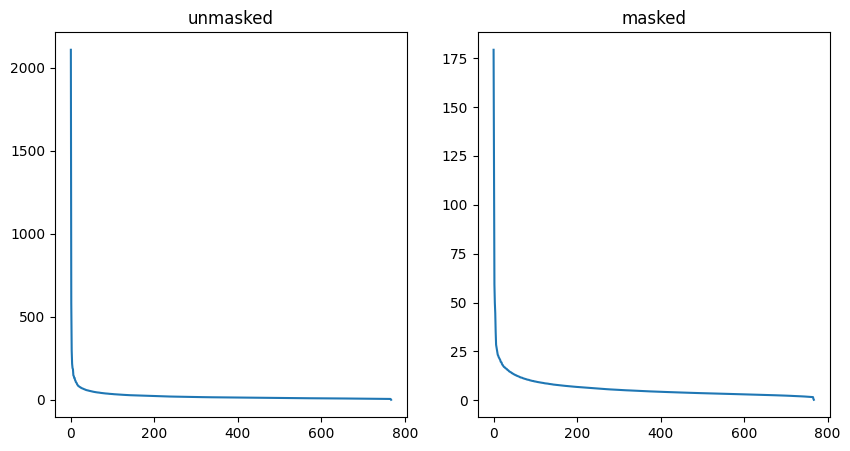

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].plot(diff_matrix[1],)
ax[0].title.set_text("unmasked")
ax[1].plot(diff_matrix_masked[1])
ax[1].title.set_text("masked",)

In [76]:
proj = torch.tensor(diff_matrix_masked[2][-5:]).T

In [77]:
# proj = torch.tensor(np.vstack((diff_matrix_masked[2][:3], diff_matrix_masked[2][-2:]))).T

In [78]:
proj.shape

torch.Size([768, 5])

In [79]:
del diff_matrix, diff_matrix_masked

In [80]:
optimizer = optim.Adafactor(model.parameters(), lr=learning_rate)
# criterion = CosLoss(alpha=0.5, vec=vec)
# criterion = nn.CosineEmbeddingLoss()
criterion = ProjectionLoss(subspace_matrix=proj, weight_cosine=weight_cosine, weight_projection=weight_projection)

num_training_steps = int(num_epochs * len(dl) / n_cosine * n_mlm)

In [81]:
# number of lr sheduler updates
num_training_steps

16820

### Learning rate & averaging

In [82]:
if not USE_SWA:
    
    lr_scheduler = get_scheduler(
                    name="cosine", optimizer=optimizer, num_warmup_steps=num_warmup_steps,
                    num_training_steps=num_training_steps
                    )

    # make steps at the end of first 5 epochs -- may be object to change made explicitely
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
    #                                                     milestones=[int(len(dl)*i/n_cosine*n_mlm) for i in range(1, num_epochs)],
    #                                                     gamma=0.8,)
    
    # # Note: Averaged model is applicable to custom modules -- not only full models, 
    # so it can be used for module training as well
    if USE_EMA:
        avg_model = ema_swa_utils.AveragedModel(model,  
                                                multi_avg_fn=ema_swa_utils.get_ema_multi_avg_fn(decay=EMA_DECAY)).to(device)

elif USE_SWA:
    avg_model = ema_swa_utils.AveragedModel(model,
                                           multi_avg_fn=ema_swa_utils.get_swa_multi_avg_fn()).to(device)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                        milestones=[int(len(dl)*i/n_cosine*n_mlm)for i in range(1, num_epochs)][:3],
                                                        gamma=0.5,)
    # ex. after 5 epochs
    logger.info(f"Using swa after {SWA_START} epochs")
    # grows swa learning rate from current optimizer value till the SWA_lr,
    # anneal epochs determines the number of steps necessary
    # may be it's plausible to change from our current implementation to the epoch-wise stepping
    swa_scheduler = ema_swa_utils.SWALR(optimizer=optimizer, 
                                    swa_lr=SWA_LR,
                                    anneal_strategy="cos",
                                    anneal_epochs=3)
    

### Training

In [83]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [84]:
print(DESCRIPTION)



Description: test run with all computations but for mlm loss only -- useful for comparison, all weights trained;

Model: based on rubert, additionally pretrained for 10 epochs;
Checkpoint: ckpt/pretrained_bert/model_epoch_10.pt;
Context: 64;
Batch size: 16;

Loss: just mlm; 
MLM type: token masking;

All the other parameters are taken as usual -- but for now we only update mlm and do it for each batch, not every 10. 

N_MLM: 1;
N_Cosine: 10;
Division_layer: 3;
weight_mlm: 1;
weight_loss: 1, constant; -- weight_cosine: 1.2, 
                            weight_projection: 0.9;


LR_SCHEDULER: Cosine annealing with warmup;
Initial learning rate: 0.0003;
Warmup_steps: 2000;
Steps: 5, 
Decay: None,
Epochs: 5;

Additional parameters and notes:
EMA: False;
EMA_DECAY: 0.999;

SWA: False;
SWA_START: 4;
SWA_LR: 0.05;




In [85]:
logger.info(DESCRIPTION)

In [ ]:
# put description to minio before proceeding
minio.put_object(DESCRIPTION, 
                save_name=f"ckpt/{TRY_NAME}/DESCRIPTION.txt", pickle=True)

# train model
tda_save_dict = defaultdict(dict)

try:
    with torch.autocast("cuda"): 
        train(model=model, criteria=criterion, optimizer=optimizer,
              lr_scheduler=lr_scheduler, data=dl, hom_data=dl_tda,
              n_epochs=num_epochs,
              n_cosine=n_cosine, division_layer=division_layer+1,
              weight_mlm=weight_mlm, weight_loss=weight_loss,
              save_every_epoch=2, test_every=3000)

except KeyboardInterrupt:
    pass
finally:
    minio.put_object(DESCRIPTION, 
                save_name=f"ckpt/trained_models/{TRY_NAME}/DESCRIPTION.txt", pickle=True)
    # in case we use averaging optimization -- we need to recalculate batch | layer normalization before inference
    if (USE_EMA | USE_SWA):
        torch.optim.swa_utils.update_bn(dl, avg_model)
    
    # save to trained models
    logger.info("Saving model...")
    buffer = io.BytesIO()
    
    if (USE_EMA | USE_SWA):
        torch.save({
            'model_state_dict': avg_model.state_dict(),
                    }, f=buffer)
    else:
        torch.save({
            'model_state_dict': model.state_dict(),
                    }, f=buffer)
    
    minio.put_object(buffer.getvalue(), 
                     save_name=f"ckpt/trained_models/{TRY_NAME}/model.pt")
    
    minio.fput_object(file_path=path.joinpath("base.anisotropy"),
                      object_name=f"ModularLM/ckpt/trained_models/{TRY_NAME}/base.anisotropy.log")
    
    minio.fput_object(file_path=path.joinpath("polypers.anisotropy"),
                      object_name=f"ModularLM/ckpt/trained_models/{TRY_NAME}/polypers.anisotropy.log", )
    
    minio.fput_object(file_path=path.joinpath("base.ph_dim"),
                      object_name=f"ModularLM/ckpt/trained_models/{TRY_NAME}/base.ph_dim.log")
    minio.fput_object(file_path=path.joinpath("polypers.ph_dim"),
                      object_name=f"ModularLM/ckpt/trained_models/{TRY_NAME}/polypers.ph_dim.log")
    minio.fput_object(file_path=path.joinpath("base.tda_feats"),
                      object_name=f"ModularLM/ckpt/trained_models/{TRY_NAME}/base.tda_feats.log")
    minio.fput_object(file_path=path.joinpath("polypers.tda_feats"),
                      object_name=f"ModularLM/ckpt/trained_models/{TRY_NAME}/polypers.tda_feats.log")

ModularLM/ckpt/plain_mlm_test_all_layers/DESCRIPTION.txt: |####################| 0.00 MB/0.00 MB 100% [elapsed: 00:00 left: 00:00,  0.34 MB/sec]

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/33640 [00:00<?, ?it/s]

ModularLM/data/TDA_FEATURES/tda_save_dict_plain_mlm_test_all_layers.pkl: |####################| 17.06 MB/17.06 MB 100% [elapsed: 00:00 left: 00:00, 369.90 MB/sec]Saving model checkpoint...
ModularLM/data/TDA_FEATURES/tda_save_dict_plain_mlm_test_all_layers.pkl: |####################| 31.28 MB/31.28 MB 100% [elapsed: 00:00 left: 00:00, 123.42 MB/sec] 

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()